In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np

def init_weights(m):
    if isinstance(m, nn.Linear):
        #nn.init.xavier_normal_(m.weight)  # или другой метод
        nn.init.kaiming_normal_(m.weight, nonlinearity='tanh')
        #m.weight.data *= 10
        nn.init.constant_(m.bias, 0.5)
        #m.bias.data += 0.05 * torch.randn_like(m.bias)

class PeriodicLayer(nn.Module):
    """
    Periodic feature mapping layer.

    This layer transforms selected input features into a periodic (Fourier-style) embedding.
    For each input feature `x_i` that is not in `keep_dims`, it produces the following features:

        [1, cos(ω_i*x_i), cos(2*ω_i*x_i), ..., cos(m*ω_i*x_i),
             sin(ω_i*x_i), sin(2*ω_i*x_i), ..., sin(m*ω_i*x_i)]

    Features specified in `keep_dims` are left unchanged and appended to the output.

    From the article "Sifan Wang, Shyam Sankaran: Respecting causality is all you need 
    for training physics-informed neural networks"

    Attributes:
        in_features (int): Number of input features.
        m (int): Number of harmonics (max multiplier for sine/cosine) for embedding.
        omega (list[float]): Frequency scaling for each input feature.
        keep_dims (list[int] or None): Indices of input features to leave unchanged.
        embed_dims (list[int]): Indices of input features to apply periodic embedding.
        _coeffs (torch.Tensor): Precomputed coefficients for embedding computation.
    """
    def __init__(self, in_features: int, m: int, omega: float | list[float], keep_dims: None | list[int] = None):
        """
        Initialize the PeriodicLayer.

        Args:
            in_features (int): Number of input features (dimensionality of input tensor).
            m (int): Number of harmonics to use for sine and cosine embeddings.
            omega (float or list of float): Frequency scaling. If a single float is provided, it is
                applied to all input features. If a list is provided, its length must equal `in_features`.
            keep_dims (list[int] or None, optional): Indices of input features that should
                be kept as-is (not transformed). Default is None (all features are transformed).
        """
        super().__init__()

        self.in_features = in_features
        self.m = m
        if isinstance(omega, (int, float)):
            self.omega = [omega] * in_features
        elif isinstance(omega, list):
            if len(omega) != in_features:
                raise ValueError("Length of omega list must equal in_features!")
            self.omega = omega[:]

        self.keep_dims = None if keep_dims is None else keep_dims[:]
        
        if keep_dims is None:
            embed_dims = list(range(in_features))
        else:
            embed_dims = [i for i in range(in_features) if i not in keep_dims]
            if len(embed_dims) == 0:
                raise ValueError("'keep_dims' list must not cover all the input features!")
        self.embed_dims = embed_dims

        self.register_buffer('_coeffs', torch.tensor([[(i + 1) * self.omega[j] for j in self.embed_dims] for i in range(self.m)]))

        self.out_features = len(embed_dims) * (1 + 2*m)
        if  isinstance(self.keep_dims, list):
            self.out_features += len(self.keep_dims)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the PeriodicLayer.

        Args:
            x (torch.Tensor): Input tensor of shape `(batch_size, in_features)`.

        Returns:
            torch.Tensor: Output tensor with shape `(batch_size, output_features)` where
                `output_features = len(embed_dims) * (2*m + 1) + len(keep_dims)`.
                Contains periodic embeddings for selected features and raw values for `keep_dims`.
        """
        ones_tensor = x.new_ones((x.shape[0], len(self.embed_dims)))
        x_embed = x[:, self.embed_dims]
        tmp = x_embed * self._coeffs
        result = torch.cat( (ones_tensor, torch.cos(tmp), torch.sin(tmp)), dim=1 )
        if self.keep_dims is None:
            return result
        else:
            return torch.cat((result, x[:, self.keep_dims]), dim=1)
        
u_exact = lambda x: -1.0/2.0 * torch.sin(x)

# --- ЗАДАНИЕ ПАРАМЕТРОВ ДЛЯ ОБУЧЕНИЯ И ЕГО ЗАПУСК ---
domain = [0, 2.0*torch.pi]
n = 100
m = 1
n_epochs = 5000

device = 'cuda'
torch.manual_seed(2008)
model = nn.Sequential(
    PeriodicLayer(1, m, omega=1.0), 
    nn.Linear(2*m + 1, 256), nn.Tanh(),
    nn.Linear(256, 1)
).to(device=device)

#model.apply(init_weights)

optimizer=torch.optim.Adam(model.parameters(), lr=1e-3)
loss = torch.zeros(n_epochs)
err_r_l2 = torch.zeros(n_epochs)
err_bc_l2 = torch.zeros(n_epochs)
res_l2 = torch.zeros(n_epochs)
x_bc = torch.tensor([[domain[0]], [domain[1]]], device=device)
for k in range(1, n_epochs + 1):
    x = (domain[1] - domain[0]) * torch.rand(n, 1, device=device) + domain[0]
    x.requires_grad_(True)
    u = model(x)
    du_dx = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    d2u_dx2 = torch.autograd.grad(du_dx, x, torch.ones_like(du_dx), create_graph=True)[0]

    optimizer.zero_grad()
    tmp_r = torch.mean((d2u_dx2 - u - torch.sin(x))**2)
    #loss_mean = torch.mean(u)**2          # encourage mean=0
    #loss_var  = (torch.var(u) - 1.0)**2  # encourage variance=1
    #tmp = tmp_r + loss_var
    tmp = tmp_r
    tmp.backward()
    optimizer.step()
    loss[k-1] = tmp.detach().cpu()

    with torch.no_grad():
        err_r = model(x) - u_exact(x)
        err_bc = model(x_bc) - u_exact(x_bc)
        err_r_l2[k-1] = torch.mean(err_r**2)
        err_bc_l2[k-1] = torch.mean(err_bc**2)
        res_l2[k-1] = torch.mean( ( d2u_dx2 - u - torch.sin(x) )**2 )

    if k == 1 or k % 100 == 0:
        print(f"epoch = {k:6d}, loss = {loss[k-1]:10.4e}, err_r_l2 = {err_r_l2[k-1]:10.4e}, err_bc_l2 = {err_bc_l2[k-1]:10.4e}, res_l2 = {res_l2[k-1]:10.4e}")


d:\Учёба\adf\Скрипты\NN_pytorch_BVP\.venv\Lib\site-packages\torch\autograd\graph.py:841: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:270.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


epoch =      1, loss = 7.7611e-01, err_r_l2 = 2.0493e-01, err_bc_l2 = 8.4123e-02, res_l2 = 7.7611e-01
epoch =    100, loss = 1.0852e-04, err_r_l2 = 5.1453e-06, err_bc_l2 = 2.4501e-07, res_l2 = 1.0852e-04
epoch =    200, loss = 4.8059e-05, err_r_l2 = 2.9089e-07, err_bc_l2 = 5.5602e-08, res_l2 = 4.8059e-05
epoch =    300, loss = 2.5037e-05, err_r_l2 = 3.1072e-07, err_bc_l2 = 5.2364e-09, res_l2 = 2.5037e-05
epoch =    400, loss = 1.9053e-05, err_r_l2 = 1.8876e-07, err_bc_l2 = 4.9987e-09, res_l2 = 1.9053e-05
epoch =    500, loss = 8.9752e-06, err_r_l2 = 1.9922e-07, err_bc_l2 = 2.7729e-08, res_l2 = 8.9752e-06
epoch =    600, loss = 5.1237e-06, err_r_l2 = 2.7942e-07, err_bc_l2 = 3.7597e-07, res_l2 = 5.1237e-06
epoch =    700, loss = 3.7612e-06, err_r_l2 = 2.0098e-08, err_bc_l2 = 1.1673e-09, res_l2 = 3.7612e-06
epoch =    800, loss = 2.8906e-06, err_r_l2 = 2.1665e-07, err_bc_l2 = 4.9552e-07, res_l2 = 2.8906e-06
epoch =    900, loss = 1.6464e-06, err_r_l2 = 1.3323e-07, err_bc_l2 = 1.0484e-07, 

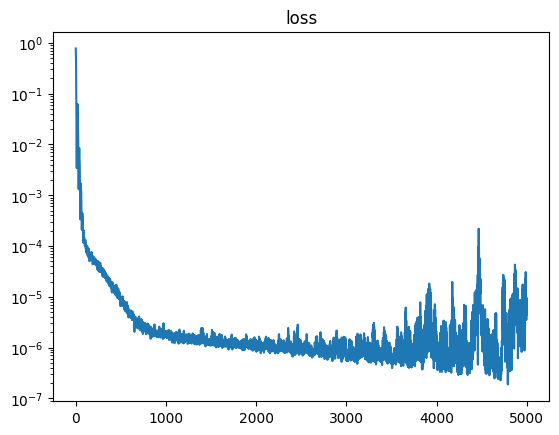

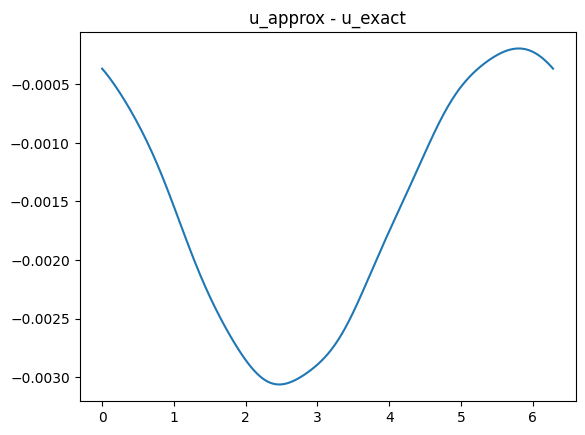

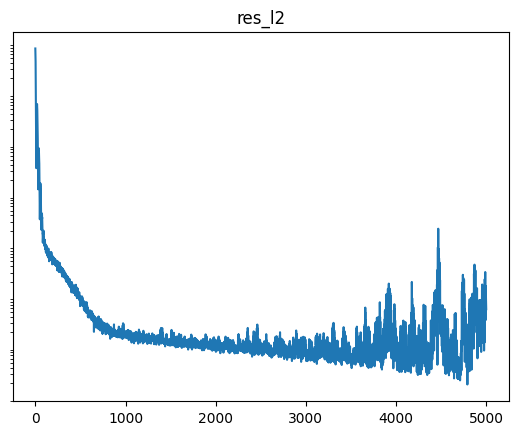

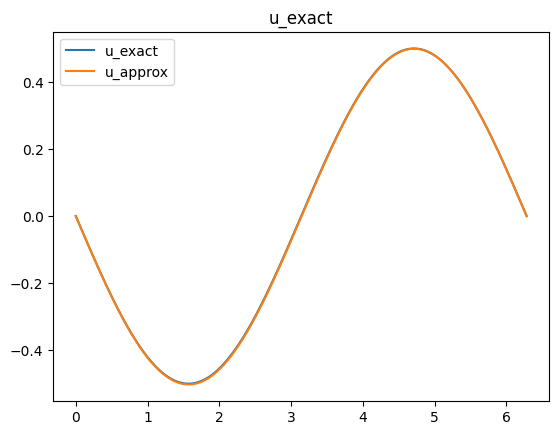

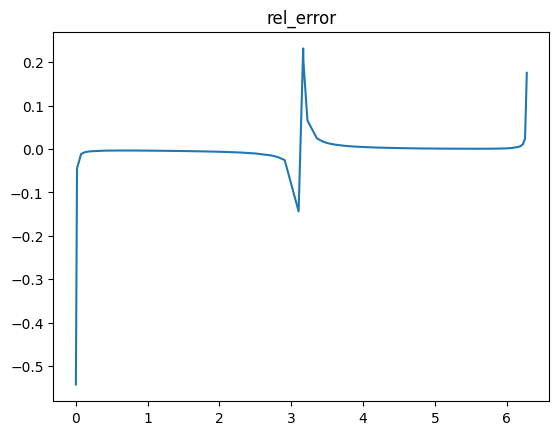

In [3]:
with torch.no_grad():
    plt.semilogy(loss)
    plt.title("loss")
    plt.show()

    model = model.to("cpu")
    x = torch.linspace(*domain, 1000).reshape(-1, 1)
    plt.plot(x, model(x) - u_exact(x))
    plt.title("u_approx - u_exact")
    plt.show()

    plt.plot(res_l2)
    plt.semilogy("res_l2")
    plt.title("res_l2")
    plt.show()

    plt.plot(x, u_exact(x), label="u_exact")
    plt.plot(x, model(x), label="u_approx")
    plt.title("u_exact")
    plt.legend()
    plt.show()

    x = (domain[1] - domain[0]) * torch.rand(100, 1) + domain[0]
    x, _ = torch.sort(x, dim=0)
    plt.plot(x, torch.abs(model(x) - u_exact(x)) / u_exact(x))
    plt.title("rel_error")
    plt.show()

Проверка частичной периодичности (не по всем входным параметрам)

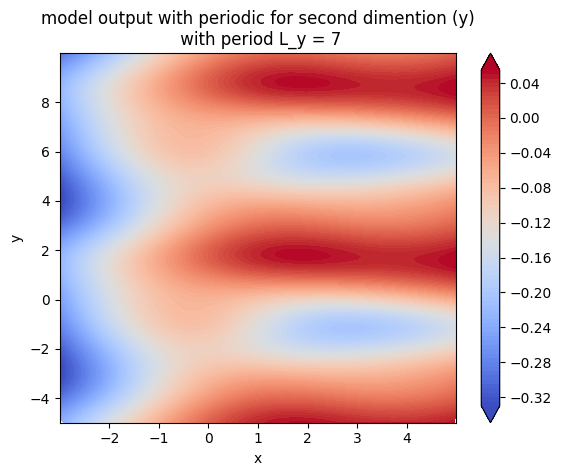

In [20]:
def sample_points_2D(bounds: list[float], n: int, device: torch.device = torch.device("cpu")) -> torch.Tensor:
    x_min, y_min, x_max, y_max = bounds
    
    xy = torch.rand(n, 2, device=device)
    xy[:, 0] = xy[:, 0] * (x_max - x_min) + x_min
    xy[:, 1] = xy[:, 1] * (y_max - y_min) + y_min 
    return xy

device = 'cpu'
lx, ly = 2, 7
periodic_layers = PeriodicLayer(2, m, omega=[2*torch.pi/lx, 2*torch.pi/ly], keep_dims=[0])
model2 = nn.Sequential(
    periodic_layers, 
    nn.Linear(periodic_layers.out_features, 256), nn.Tanh(),
    nn.Linear(256, 1)
).to(device=device)

domain = [-3, 5, -5, 10]
xy = sample_points_2D(bounds=[domain[0], domain[2], domain[1], domain[3]], n=30000, device=device)
u = model2(xy)

with torch.no_grad():
    fig, ax = plt.subplots()
    triang = tri.Triangulation(xy[:, 0], xy[:, 1])
    tcf = plt.tricontourf(triang, u.squeeze(), levels=80, extend='both', cmap='coolwarm')
    fig.colorbar(tcf)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(f"model output with periodic for second dimention (y)\n with period L_y = {ly:d}")